
🏆 Resume Leaderboard:

Rank 1: Vedant_Kate_Resume_Final.pdf — Score: 71.3
Intro: Entry-Level Software Engineer | Java, Python, JavaScript | Passion for Clean Code & Full Software
Email: katevedant451@gmail.com, Phone: +91 7558325182

Skills: ['Python', 'SQL', 'TensorFlow', 'Java', 'C']
Certifications: 1, Leadership: 2, Achievements: 6
------------------------------------------------------------
Rank 2: resume (3) (1).pdf — Score: 49.86
Intro: VishwakarmaInstituteofTechnology Pune,India
Email: pranav.patel0015@gmail.com, Phone: +91-9158061370 
Skills: ['Python', 'SQL', 'Java', 'C']
Certifications: 0, Leadership: 0, Achievements: 6
------------------------------------------------------------


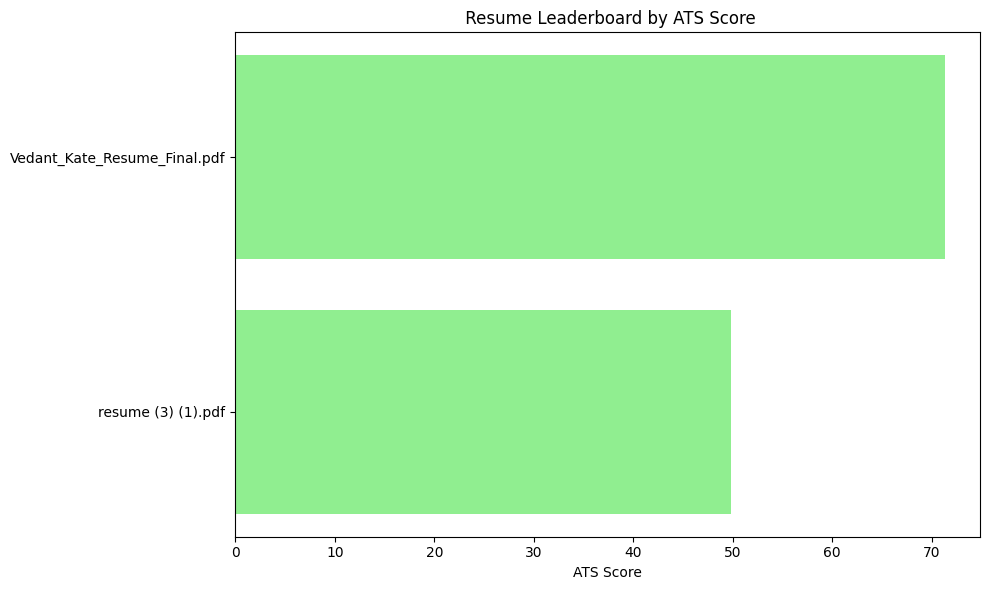

In [1]:
import re
import pdfplumber
from pathlib import Path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1. Extract text from PDF
def extract_text_from_resume(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

# 2. Extract contact info (email, phone)
def extract_contact_info(text):
    email = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    phone = re.search(r"\+?\d[\d\s\-]{9,15}", text)
    return {
        "Email": email.group() if email else "Not found",
        "Phone": phone.group() if phone else "Not found"
    }

# 3. Extract intro line
def extract_intro_line(text):
    lines = text.split("\n")
    for line in lines:
        if len(line.strip()) > 30 and not any(word in line.lower() for word in ["email", "linkedin", "phone"]):
            return line.strip()
    return "Not found"

# 4. Extract professional summary
def extract_professional_summary(text):
    match = re.search(r"(professional summary|profile|summary of qualifications)[\s:\-]*([\s\S]{50,500})", text, re.IGNORECASE)
    return match.group(2).strip().split("\n")[0] if match else "Not found"

# 5. Score skills
def score_skills(required_skills, resume_text):
    found_skills = [s for s in required_skills if s.lower() in resume_text.lower()]
    return round(len(found_skills) / len(required_skills) * 40, 2), found_skills

# 6. Score experience titles
def score_experience_titles(resume_text, relevant_titles):
    matched = sum(title.lower() in resume_text.lower() for title in relevant_titles)
    return round((matched / len(relevant_titles)) * 20, 2), matched

# 7. Score education
def score_education(resume_text, min_education_keywords):
    matched = any(edu.lower() in resume_text.lower() for edu in min_education_keywords)
    return 10 if matched else 0

# 8. Score soft skills
def score_soft_skills(resume_text, soft_skills_keywords):
    matched = sum(kw.lower() in resume_text.lower() for kw in soft_skills_keywords)
    return round(min(matched, len(soft_skills_keywords)) / len(soft_skills_keywords) * 10, 2), matched

# 9. JD similarity score
def score_similarity(jd_text, resume_text):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = vectorizer.fit_transform([jd_text, resume_text])
    score = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
    return round(score * 20, 2)

# 10. Bonus section
def score_achievements(resume_text):
    certs = re.findall(r"(certified|certification|AWS Certified|Google Certified)", resume_text, re.IGNORECASE)
    leadership = re.findall(r"(team lead|president|vice president|mentor|leadership)", resume_text, re.IGNORECASE)
    hackathons = re.findall(r"(hackathon|winner|achievement|finalist|runner[-\s]?up|prize|award)", resume_text, re.IGNORECASE)

    total_bonus = min(len(certs) + len(leadership) + len(hackathons), 5) * 2  # Max 10
    return {
        "Certifications Found": len(certs),
        "Leadership Roles Found": len(leadership),
        "Hackathon/Achievements Found": len(hackathons),
        "Bonus Score (max 10%)": total_bonus
    }

# 11. Master score calculation
def ats_score(jd_text, resume_text):
    required_skills = ["Python", "AWS", "SQL", "TensorFlow", "Java", "C++", "C"]
    relevant_titles = ["software engineer", "backend developer", "ml engineer"]
    education_keywords = ["bachelor", "b.tech", "m.tech", "degree", "computer science"]
    soft_skills = ["git", "docker", "team", "communication", "problem solving"]

    contact_info = extract_contact_info(resume_text)
    intro_line = extract_intro_line(resume_text)
    professional_summary = extract_professional_summary(resume_text)

    skill_score, skills_found = score_skills(required_skills, resume_text)
    experience_score, titles_matched = score_experience_titles(resume_text, relevant_titles)
    education_score = score_education(resume_text, education_keywords)
    soft_score, soft_matched = score_soft_skills(resume_text, soft_skills)
    similarity_score = score_similarity(jd_text, resume_text)
    bonus_result = score_achievements(resume_text)

    total_score = round(skill_score + experience_score + education_score + soft_score + similarity_score + bonus_result["Bonus Score (max 10%)"], 2)

    return {
        "Candidate Intro Line": intro_line,
        "Professional Summary": professional_summary,
        "Email": contact_info["Email"],
        "Phone": contact_info["Phone"],
        "Total ATS Score (out of 100)": total_score,
        "Skill Match Score (40%)": skill_score,
        "Skills Found": skills_found,
        "Experience Score (20%)": experience_score,
        "Matched Titles": titles_matched,
        "Education Score (10%)": education_score,
        "Soft Skill Score (10%)": soft_score,
        "Soft Skills Found": soft_matched,
        "Similarity Score (20%)": similarity_score,
        **bonus_result
    }

# 12. Process all resumes
def process_all_resumes(jd_text, resume_folder_path):
    results = []
    folder = Path(resume_folder_path)

    for pdf_file in folder.glob("*.pdf"):
        try:
            resume_text = extract_text_from_resume(pdf_file)
            score_data = ats_score(jd_text, resume_text)
            score_data["Filename"] = pdf_file.name
            results.append(score_data)
        except Exception as e:
            print(f"Error processing {pdf_file.name}: {e}")

    return pd.DataFrame(results).sort_values(by="Total ATS Score (out of 100)", ascending=False)

# 13. Run the ranking and visualization
def run_leaderboard(jd_text, resume_folder_path):
    df = process_all_resumes(jd_text, resume_folder_path)
    df['Rank'] = range(1, len(df) + 1)

    print("\n🏆 Resume Leaderboard:\n")
    for _, row in df.iterrows():
        print(f"Rank {row['Rank']}: {row['Filename']} — Score: {row['Total ATS Score (out of 100)']}")
        print(f"Intro: {row['Candidate Intro Line']}")
        print(f"Email: {row['Email']}, Phone: {row['Phone']}")
        print(f"Skills: {row['Skills Found']}")
        print(f"Certifications: {row['Certifications Found']}, Leadership: {row['Leadership Roles Found']}, Achievements: {row['Hackathon/Achievements Found']}")
        print("-" * 60)

    # Plot chart
    plt.figure(figsize=(10, 6))
    plt.barh(df['Filename'], df['Total ATS Score (out of 100)'], color='lightgreen')
    plt.xlabel("ATS Score")
    plt.title(" Resume Leaderboard by ATS Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

#  Sample Usage
jd_text = """
We are looking for a Python backend developer with experience in AWS, SQL, and TensorFlow.
Ideal candidate has engineering degree and open source or hackathon achievements.
"""
resume_folder_path = r"D:\resume ai ranker\resumes"
run_leaderboard(jd_text, resume_folder_path)
